## Connecting Google Drive with the notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive') 


Mounted at /content/drive


In [2]:
import os,shutil
os.chdir('./drive/My Drive/')

In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

## Importing required libraries

In [3]:
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import json 
from tqdm import tqdm
import re


import keras
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import BatchNormalization,Dense , Flatten ,Embedding,Input,LSTM,Bidirectional,Conv1D,MaxPooling1D
import tensorflow as tf
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.models import Model
from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout

In [4]:
# Seed value (can actually be different for each attribution step)
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K
from tensorflow.compat.v1.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

## Loading the dataset (train, test and validation) and some basic preprocessing

In [5]:
train_df = pd.read_csv('./PUBHEALTH/train.tsv',sep="\t")
val_df = pd.read_csv('./PUBHEALTH/dev.tsv',sep="\t")
test_df = pd.read_csv('./PUBHEALTH/test.tsv',sep="\t")

In [6]:
train_df

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,false,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,mixture,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,mixture,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,true,
...,...,...,...,...,...,...,...,...,...
9827,35948,The Sturgis motorcycle rally in 2020 resulted ...,"September 10, 2020","They want to know if mass-events (protests, co...",Dan Evon,"In September 2020, social media was abuzz over...",,unproven,"Politics Medical, COVID-19"
9828,401,AstraZeneca's infant respiratory drug prioriti...,"September 25, 1995",Britain’s AstraZeneca said a potential medicin...,,The “Breakthrough Therapy” and “Prime” designa...,,true,Health News
9829,2023,Testicular cancer deaths double with after 40 ...,"February 10, 2011",Men diagnosed with testicular cancer at 40 yea...,,This was true even when initial treatment and ...,http://bit.ly/fGNEw9,true,Health News
9830,38118,The FDA published “conclusive proof” that the...,"November 22, 2017",FDA Confirms DTaP Vaccine Causes Autism in Nov...,Rich Buhler & Staff,The FDA hasn’t confirmed a link between DTaP v...,https://www.truthorfiction.com/marshall-kamena...,false,Medical


In [7]:
unproven = train_df[train_df.label == 'unproven'].append(val_df[val_df.label == 'unproven']).append(test_df[test_df.label == 'unproven'])

In [8]:
unproven = unproven.reset_index()

In [9]:
len(unproven)

377

In [10]:
val_df.label.value_counts()

true                                             629
false                                            380
mixture                                          164
unproven                                          41
National, Candidate Biography, Donald Trump,       1
Name: label, dtype: int64

In [11]:
test_df.label.value_counts()

true        599
false       388
mixture     201
unproven     45
Name: label, dtype: int64

In [12]:
train_df = train_df[(train_df['label']=='true')|(train_df['label']=='false')|(train_df['label']=='unproven')]
val_df = val_df[(val_df['label']=='true')|(val_df['label']=='false')|(val_df['label']=='unproven')]
test_df = test_df[(test_df['label']=='true')|(test_df['label']=='false')|(test_df['label']=='unproven')]

In [13]:
total_df = train_df.append(val_df).append(test_df).reset_index()

In [14]:
total_df

,index,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,Unnamed: 0
0,0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,false,"Foreign Policy, PunditFact, Newt Gingrich,",NaN
1,3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health",NaN
2,4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,true,,NaN
3,5,8713,Britain to reveal trial criteria for coronavir...,"April 7, 2020",British regulators will this week reveal appro...,Alistair Smout,Antibody tests show whether whether people hav...,,true,Health News,NaN
4,6,9851,Angioplasty through the wrist backed by new study,"August 18, 2008",This is a good piece of reporting about a rece...,,The story did not provide cost estimates for e...,,true,,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10447,1230,3295,Christmas miracle for Florida dog whose heart ...,NaN,A Florida man was hoping for a Christmas mirac...,Associated Press,The heart of Gerald Ford’s 1-year-old French b...,https://www.gainesville.com/news/20200102/holi...,true,"Animals, Health, Florida, General News, Gaines...",1230.0
10448,1231,6904,Another dolphin dies at Arizona aquatic facility.,NaN,A fourth dolphin has died at a Phoenix-area aq...,,A statement from Dolphinaris Arizona in Scotts...,,true,"Arizona, Animals, Phoenix, Health, Dolphins",1231.0
10449,1232,13874,"What the facts say"" is ... ""the best scenario ...","July 17, 2016","Priebus said, ""What the facts say"" is ... ""the...",Lauren Carroll,Republican National Committee chairman Reince ...,https://www.nytimes.com/2016/07/13/us/politics...,false,"National, Children, Race and Ethnicity, Reince...",1232.0
10450,1233,2847,FDA advisory panel rejects J&J drug for acute ...,"January 16, 2014",Johnson & Johnson’s anticoagulant Xarelto shou...,,"The panel voted 10 to 0, with one abstention, ...",,true,Health News,1233.0


In [15]:
ctr =0 
reviews = []
for idx,i in enumerate(total_df.reset_index().main_text.values):
  if ('story' in i or 'release' in i or 'article' in i) and 'cost' in i and ('discuss' in i or 'mention' in i):
    #print(i)
    reviews.append(idx)
    ctr+=1

In [16]:
total_df.iloc[reviews]

,index,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,Unnamed: 0
1,3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,true,"Cancer,WebMD,women's health",NaN
4,6,9851,Angioplasty through the wrist backed by new study,"August 18, 2008",This is a good piece of reporting about a rece...,,The story did not provide cost estimates for e...,,true,,NaN
7,9,10527,Poor test results for heart drugs,"March 31, 2008","""The story reports no additional cardiovascula...",,"""The story does not note the cost of a typical...",,false,,NaN
10,13,11433,Cancer Activist Sounds Alarm For Early Testing...,"June 17, 2009",Fails to present the nuances associated with t...,,There is no discussion of cost in this story. ...,,false,,NaN
20,27,10931,Laser Used to Blast Away Cells Causing Irregul...,"May 27, 2010","Another HealthDay, another story straight from...",,"""No discussion of costs – a recurring and sign...",,false,,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10436,1212,9859,Problems spur FDA caution on insulin pump,"May 5, 2008","First, let’s be clear that this is a review of...",,The original AP story told readers the cost of...,,true,,1212.0
10440,1221,11003,Wrist replacement surgery is a last resort for...,"January 25, 2007",Patients who suffer with hand and wrist arthri...,,The article fails to mention the cost of treat...,,false,,1221.0
10441,1222,10772,New psoriasis drug is more effective than curr...,"July 15, 2015",The news release announces the results of a ph...,"Matt Shipman,Harold J. DeMonaco, MS,Andrew Hol...",The release does not address cost at all. Whil...,https://www.healthnewsreview.org/wp-content/up...,false,"Academic medical center news release,psoriasis",1222.0
10443,1226,10461,Researchers produce first widely protective va...,"July 26, 2016","In many ways, this release provides much of th...","William Heisel,Richard Hoffman, MD,Kathlyn Stone",Because the release is presented as if the stu...,https://www.healthnewsreview.org/wp-content/up...,false,"Academic medical center news release,Animal re...",1226.0


In [17]:
total_df.drop(labels=reviews,axis=0,inplace=True)

In [18]:
total_df

,index,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,Unnamed: 0
0,0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,false,"Foreign Policy, PunditFact, Newt Gingrich,",NaN
2,4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,true,,NaN
3,5,8713,Britain to reveal trial criteria for coronavir...,"April 7, 2020",British regulators will this week reveal appro...,Alistair Smout,Antibody tests show whether whether people hav...,,true,Health News,NaN
5,7,2768,U.S. says results encouraging for healthcare d...,"January 30, 2014",The Obama administration on Thursday reported ...,David Morgan,As part of President Barack Obama’s healthcare...,,true,Health News,NaN
6,8,2717,Latest trial in J&J talc litigations gets unde...,"January 8, 2019",A California jury on Monday heard opening stat...,Tina Bellon,The lawsuit brought by Terry Leavitt in Alamed...,"uk.reuters.com/companies/IMTP.PA,uk.reuters.co...",true,Health News,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10447,1230,3295,Christmas miracle for Florida dog whose heart ...,NaN,A Florida man was hoping for a Christmas mirac...,Associated Press,The heart of Gerald Ford’s 1-year-old French b...,https://www.gainesville.com/news/20200102/holi...,true,"Animals, Health, Florida, General News, Gaines...",1230.0
10448,1231,6904,Another dolphin dies at Arizona aquatic facility.,NaN,A fourth dolphin has died at a Phoenix-area aq...,,A statement from Dolphinaris Arizona in Scotts...,,true,"Arizona, Animals, Phoenix, Health, Dolphins",1231.0
10449,1232,13874,"What the facts say"" is ... ""the best scenario ...","July 17, 2016","Priebus said, ""What the facts say"" is ... ""the...",Lauren Carroll,Republican National Committee chairman Reince ...,https://www.nytimes.com/2016/07/13/us/politics...,false,"National, Children, Race and Ethnicity, Reince...",1232.0
10450,1233,2847,FDA advisory panel rejects J&J drug for acute ...,"January 16, 2014",Johnson & Johnson’s anticoagulant Xarelto shou...,,"The panel voted 10 to 0, with one abstention, ...",,true,Health News,1233.0


In [19]:
train_df, val_df, test_df = np.split(total_df.sample(frac=1, random_state=42), 
                       [int(.8*len(total_df)), int(.9*len(total_df))])

In [20]:
train_df.label.value_counts()

true        4458
false       2340
unproven     275
Name: label, dtype: int64

In [21]:
len(train_df)

7073

In [22]:
len(val_df)

884

In [23]:
len(test_df)

885

In [24]:
test_df.label.value_counts()

true        561
false       277
unproven     47
Name: label, dtype: int64

In [25]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [26]:
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [27]:
import string


def removeSpl(s):
  s = s.replace("\\","")
  s = s.replace(u'\xa0', u' ')
  #print(s)
  s= s.replace('-'," ")
  s = s.replace('…',' ')
  s = s.replace('_',' ')
  #s = s.replace("'","")
  translator = str.maketrans(string.punctuation.replace("'",""), ' '*len(string.punctuation.replace("'","")))
  s = s.translate(translator)
  s = s.replace("’", "'")
  s= s.replace('“',' ')
  s = s.replace('”', ' ')
  s = s.replace("‘","'")
  for word in s.split():
    if word.lower() in contractions:
        #print(word)
        s = s.replace(word, contractions[word.lower()])

  s = s.replace("'",'')
  return s

def toLower(s):
   return s.lower()


def removeURLs(s):
  return re.sub(r'http\S+', ' ', s)

nltk.download('stopwords')
stop = list(set(nltk.corpus.stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
train_df.iloc[137].main_text

'"The U.S. Senate health care bill would allow states to waive federal requirements for what insurance plans must cover. With state waivers, insurers could skip coverage of what the current Affordable Care Act now requires to be covered, known as essential health benefits like prescription drugs, laboratory services and hospitalization. Health insurance companies in those states would be able to sell lower-priced plans with less coverage. The House included the same provision in its Obamacare replacement bill, the American Health Care Act. Rep. John Faso,\xa0a Hudson Valley Republican, defended the provision in a radio town hall before the Senate version was released. ""I read this provision extremely closely, and I don’t believe many, if any, governors will actually seek these waivers. It’s an extraordinarily limited waiver,"" Faso said. ""It doesn’t apply to things like maternity coverage."" A spokesperson from Faso’s office said he was talking about how coverage for maternity care w

In [30]:
removeSpl(train_df.iloc[137].main_text)

' The U S  Senate health care bill would allow states to waive federal requirements for what insurance plans must cover  With state waivers  insurers could skip coverage of what the current Affordable Care Act now requires to be covered  known as essential health benefits like prescription drugs  laboratory services and hospitalization  Health insurance companies in those states would be able to sell lower priced plans with less coverage  The House included the same provision in its Obamacare replacement bill  the American Health Care Act  Rep  John Faso  a Hudson Valley Republican  defended the provision in a radio town hall before the Senate version was released    I read this provision extremely closely  and I do not believe many  if any  governors will actually seek these waivers  it has / it is an extraordinarily limited waiver    Faso said    It does not apply to things like maternity coverage    A spokesperson from Fasos office said he was talking about how coverage for maternit

## Data Augmentation

In [31]:
aug = pd.read_csv('aug_articles_translate_all2.csv')

In [32]:
aug.label.value_counts()

true        10085
false        5993
unproven      586
Name: label, dtype: int64

In [33]:
train_df.label.value_counts()

true        4458
false       2340
unproven     275
Name: label, dtype: int64

In [34]:
aug.claim_id = aug.claim_id.astype(str)

In [35]:

common1 = aug.merge(test_df,on=['claim_id'])

In [36]:
common2 = aug.merge(val_df,on=['claim_id'])

In [37]:
len(common1)

1401

In [38]:
len(common2)

1397

In [39]:
aug_train = aug[(~aug.claim_id.isin(common1.claim_id))&(~aug.claim_id.isin(common2.claim_id))]

In [40]:
aug_train.head(20)

,label,main_text,claim_id
0,false,Hillary Clinton is in the political crosshairs...,15661
1,false,"""Hillary Clinton is in the political crosshair...",15661
2,true,"The story speaks of costs, but the framing is ...",10166
3,true,"The story is about cost, but the design is pro...",10166
4,true,"""Although the article did not mention the cost...",11276
5,true,"""Although the story did not mention the cost o...",11276
8,true,The article did not provide a cost estimate fo...,9851
9,true,History did not provide cost estimates for eit...,9851
14,false,“History does not show the cost of a typical s...,10527
15,false,"""The story makes no mention of the cost of a t...",10527


In [41]:
aug_train = aug_train.reset_index()

In [42]:
aug_temp = aug_train.sample(n=13164,random_state=21)

In [43]:
len(train_df)

7073

In [44]:
#aug_temp = aug[aug.label == 'false' ].sample(n=1786,random_state=21)

In [45]:
temp = train_df.append(aug_temp).drop_duplicates()

In [46]:
temp = temp[['label','main_text','claim_id']]

In [47]:
temp.label.value_counts()

true        12355
false        7172
unproven      710
Name: label, dtype: int64

In [48]:
train_df[train_df.claim_id == '3077'].main_text.values[0]

'Officials discovered that there were 182 intravenous drug users who were affected in Lowell and Lawrence between 2015 and 2019, The Boston Globe reported. The number of cases dropped after the summer of 2018 after a campaign to increase access to treatment. There were six new cases diagnosed in Boston in December 2018 before a similar campaign was launched, and cases dropped down until fall of 2019. “We do seem to see a growing number of very, very vulnerable people with substance use disorder, with injection drug use, in great need for care,” said Dr. Jennifer K. Brody, director of HIV services at the Boston Health Care for the Homeless Program. The state has increased the number of needle exchanges from five in 2015 to 33, in an attempt to provide clean injection supplies and training, the paper reported. Infections among people who inject drugs declined 91% between 2000 and 2014. “What we’re seeing is the need for much more aggressive street outreach,” said Carl Sciortino, vice pre

In [49]:
aug_train[aug_train.claim_id == '3077'].main_text.values[0]

'Authorities discovered that 182 people who inject drugs were affected in Lowell and Lawrence between 2015 and 2019, the Boston Globe reported. The number of cases fell after the summer of 2018 after a campaign to improve access to treatment. There were six new cases diagnosed in Boston in December 2018 before a similar campaign was launched, and cases dropped until the fall of 2019. “We seem to see a growing number of very, very vulnerable people with substance use disorders, with injection drug use, which is in great need of care, ”said Dr. Jennifer K. Brody, director of HIV services at Boston Health Care for the Homeless Program. The state increased the number of needle exchanges from five in 2015 to 33, with the aim of providing clean injection supplies and training, the newspaper reported. Infections among people who inject drugs declined 91% between 2000 and 2014. "What we are seeing is the need for much more aggressive street outreach," said Carl Sciortino, vice president of rel

In [50]:
aug_train[aug_train.claim_id == '3077'].main_text.values[1]

'According to The Boston Globe, 182 intravenous drug users were affected between 2015 and 2019 in Lowell and Lawrence. The number of cases decreased after the summer of 2018 following a campaign to improve access to treatment. In December 2018, six new cases were diagnosed in Boston before a similar campaign was launched, and cases declined by fall 2019. "We seem to be seeing a growing number of very, very vulnerable people with substance use disorders and injectable drug use in dire need of care," said Dr. Jennifer K. Brody, director of HIV services at Boston Health Care for the Homeless Program. The state has increased the number of needle changes from five in 2015 to 33 to ensure clean injection supply and training, the paper reported. Infections in people who inject drugs decreased 91% between 2000 and 2014. "We see the need for much more aggressive public relations on the street," said Carl Sciortino, vice president of government relations for Fenway Health.'

In [51]:
temp = temp.reset_index()

In [52]:
labels = {'true':1,'false':0,'unproven':0}

In [53]:
temp.label = [labels[item] for item in temp.label]

In [54]:
train_df.label = [labels[item] for item in train_df.label]

In [55]:
test_df.label = [labels[item] for item in test_df.label]

In [56]:
val_df.label = [labels[item] for item in val_df.label]

In [57]:
len(temp)

20237

## Cleaning text and converting it into tokens

In [58]:
preprocessed_articles = []
for i,sentance in tqdm(enumerate(temp['main_text'].values[:])):
   # print(sentance)
    #print(i)
    sentance = removeURLs(sentance)
   # print(sentance)
    sentance = toLower(sentance)
    #print(sentance)
    sentance = removeSpl(sentance)
    #print(sentance)
    #sentance = ' '.join(e.lower() for e in sentance.split())
    #print(sentance)
    preprocessed_articles.append(sentance.split())
    #temp['main_text'] = temp['main_text'].replace([temp[temp.index==i]['main_text'].values[0]],sentance)
    #print(temp[temp.index==i]['main_text'].values[0])
  

20237it [00:11, 1776.66it/s]


In [59]:
preprocessed_articles_test = []
for i,sentance in tqdm(enumerate(test_df['main_text'].values[:])):
   # print(sentance)
    #print(i)
    sentance = removeURLs(sentance)
   # print(sentance)
    sentance = toLower(sentance)
    #print(sentance)
    sentance = removeSpl(sentance)
    #print(sentance)
    sentance = ' '.join(e.lower() for e in sentance.split())
    #print(sentance)
    preprocessed_articles_test.append(sentance.split())
   # temp['main_text'] = temp['main_text'].replace([temp[temp.index==i]['main_text'].values[0]],sentance)

885it [00:00, 1372.03it/s]


In [60]:
preprocessed_articles_val = []
for i,sentance in tqdm(enumerate(val_df['main_text'].values[:])):
   # print(sentance)
    #print(i)
    sentance = removeURLs(sentance)
   # print(sentance)
    sentance = toLower(sentance)
    #print(sentance)
    sentance = removeSpl(sentance)
    #print(sentance)
    #sentance = ' '.join(e.lower() for e in sentance.split())
    #print(sentance)
    preprocessed_articles_val.append(sentance.split())

884it [00:00, 1642.14it/s]


In [61]:
temp.label.value_counts()

1    12355
0     7882
Name: label, dtype: int64

In [62]:
x_train = preprocessed_articles
x_test = preprocessed_articles_test
x_val = preprocessed_articles_val


In [63]:
y_train = temp.label
y_test = test_df.label
y_val = val_df.label

In [64]:
len(x_train)

20237

In [65]:
len(y_train)

20237

##Tokenizer

In [66]:
tok = Tokenizer()
tok.fit_on_texts(x_train)
tok.fit_on_texts(x_val)
#tok.fit_on_texts(x_test)
encd_rev_train = tok.texts_to_sequences(x_train)
encd_rev_test = tok.texts_to_sequences(x_test)
encd_rev_val = tok.texts_to_sequences(x_val)

## Padding

In [67]:
maxi = 0
sum = 0
for i in preprocessed_articles:
  #if len(i) > 1000:
  sum+=len(i)
  if len(i)>maxi:
    maxi = len(i)

maxi

7040

In [68]:
sum/len(preprocessed_articles)

687.9869051736918

In [69]:
max_rev_len= 2000  # max length of a review
size_of_vocabulary=len(tok.word_index) + 1 #+1 for padding
print(size_of_vocabulary)
#embed_dim= 50 # embedding dimension as choosen in word2vec constructor

97196


In [70]:
pad_rev_train = pad_sequences(encd_rev_train, maxlen=max_rev_len, padding='pre')
pad_rev_test = pad_sequences(encd_rev_test, maxlen=max_rev_len, padding='pre')
pad_rev_val = pad_sequences(encd_rev_val, maxlen=max_rev_len, padding='pre')
pad_rev_train.shape 

(20237, 2000)

## Pretrained Glove Embeddings

In [71]:
embeddings_index = dict()
f = open('./glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [72]:
# create a weight matrix for words in training docs
embed_matrix = np.zeros((size_of_vocabulary, 300))
ctr=0
for word, i in tok.word_index.items():
    word = word.translate(str.maketrans("", "", string.punctuation))
    word = word.split('—')[0]
    word = word.split('–')[0]
    embedding_vector = embeddings_index.get(word.lstrip().rstrip())
    if embedding_vector is None:
      embedding_vector = embeddings_index.get(word[1:].lstrip().rstrip())
    if embedding_vector is None:
      embedding_vector = embeddings_index.get(word[:-1].lstrip().rstrip())
    if embedding_vector is not None:
        embed_matrix[i] = embedding_vector
    else:
        #print(word)
        ctr+=1


In [73]:
ctr

19271

In [74]:
embed_matrix.shape

(97196, 300)

##Model

In [75]:
from tensorflow.keras import initializers
from tensorflow.keras import regularizers,constraints
from tensorflow.keras.layers import Layer
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def get_config(self):
      config = super().get_config().copy()
      config.update({
              'W_regularizer': self.W_regularizer,
              'u_regularizer': self.u_regularizer,
              'b_regularizer': self.b_regularizer,
              'W_constraint': self.W_constraint,
              'u_constraint': self.u_constraint,
              'b_constraint': self.b_constraint,
              'bias': self.bias,
      })
      return config

    def create_custom_objects():
      instance_holder = {"instance": None}

      class ClassWrapper(AttentionWithContext):
          def __init__(self, *args, **kwargs):
              instance_holder["instance"] = self
              super(ClassWrapper, self).__init__(*args, **kwargs)

      def loss(*args):
          method = getattr(instance_holder["instance"], "loss_function")
          return method(*args)

      def accuracy(*args):
          method = getattr(instance_holder["instance"], "accuracy")
          return method(*args)
      return {"ClassWrapper": ClassWrapper ,"AttentionWithContext": ClassWrapper, "loss": loss,
              "accuracy":accuracy}

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


# def model_lstm_atten(embedding_matrix):
#     inp = Input(shape=(max_rev_len,))
#     x = Embedding(embed_matrix.shape[0], 300, weights=[embedding_matrix], trainable=False)(inp)
#     #x = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu',kernel_initializer="he_normal")(x)
#     #x = MaxPooling1D(pool_size=3)(x)
#     x = Bidirectional(LSTM(128, return_sequences=True,kernel_initializer="he_normal"))(x)
#     x = Bidirectional(LSTM(64, return_sequences=True,kernel_initializer="he_normal"))(x)
#     x = AttentionWithContext()(x)
#     x = Dense(64, activation="relu",kernel_initializer="he_normal")(x)
#     x = Dense(1, activation="sigmoid")(x)
#     model = Model(inputs=inp, outputs=x)
#     model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.003), metrics=['accuracy'])
#     return model

In [76]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Concatenate, Conv1D, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D,TimeDistributed

#from tensorflow.python.keras.optimizers import Adam


def get_model(embedding_matrix):
    input = Input(shape=(max_rev_len,))

    embedding = Embedding(embed_matrix.shape[0], 300, weights=[embedding_matrix], trainable=False)(input)

    x_context = Bidirectional(LSTM(300, return_sequences=True))(embedding)
    #x_context = TimeDistributed(Dense(300))(x_context)
    x_lstm_att = LSTM(64, return_sequences=True)(embedding)
    x_attention = AttentionWithContext()(x_lstm_att)
    
    l_x_context = x_context[:,:,:300]
    r_x_context = x_context[:,:,300:]
    # print(l_x_context.shape,r_x_context.shape)
    #x_context_attention = TimeDistributed(Dense(2000))(x_context)
    x = Concatenate()([l_x_context,embedding, r_x_context])
    print(x.shape)


    convs = []
    for kernel_size in range(1, 5):
        conv = Conv1D(64, kernel_size, activation='relu')(x)
        #print(conv.shape)
        #print(tf.reshape(x_attention, [-1, 64]))
        for j in range(max_rev_len-i):
          conv[:,j,:] = tf.math.multiply(tf.transpose(conv[:,j,:].reshape(conv.shape[0],64)),x_attention[:,:])
        #conv = tf.reshape(conv, [-1, 2000, 64])
        print(conv.shape)
        convs.append(conv)
        
    poolings = [GlobalAveragePooling1D()(conv) for conv in convs] + [GlobalMaxPooling1D()(conv) for conv in convs]
    x = Concatenate()(poolings)
    dense = Dense(64,activation='relu')(x)
    output = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0001), metrics=['accuracy'])
    return model

In [116]:
model = get_model(embed_matrix)

(None, 2000, 900)
(None, 2000, 64)
(None, 1999, 64)
(None, 1998, 64)
(None, 1997, 64)


In [117]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 2000)]       0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 2000, 300)    29158800    input_16[0][0]                   
__________________________________________________________________________________________________
bidirectional_15 (Bidirectional (None, 2000, 600)    1442400     embedding_15[0][0]               
__________________________________________________________________________________________________
tf.__operators__.getitem_26 (Sl (None, 2000, 300)    0           bidirectional_15[0][0]           
____________________________________________________________________________________________

In [118]:
es = keras.callbacks.EarlyStopping(patience=4)  
mc= keras.callbacks.ModelCheckpoint('aug_att_rmcnn_upd_best_model_test10.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1) 

### Load the saved model (will save training time) 

In [ ]:
model = keras.models.load_model('aug_att_rmcnn_upd_best_model_test10.h5',custom_objects=AttentionWithContext.create_custom_objects())

### If you loaded the saved model, DO NOT RUN the next line as it trains the model and is time taking. If hyperparametes need to be tuned, then train.

In [119]:
history = model.fit(pad_rev_train,y_train,epochs=20,batch_size=100,validation_data=(pad_rev_val,y_val),callbacks =[es,mc])

Epoch 1/20
203/203 [==============================] - 308s 1s/step - loss: 0.5395 - accuracy: 0.7150 - val_loss: 0.3448 - val_accuracy: 0.8462

Epoch 00001: val_loss improved from inf to 0.34480, saving model to aug_att_rmcnn_upd_best_model_test10.h5
Epoch 2/20
203/203 [==============================] - 275s 1s/step - loss: 0.3437 - accuracy: 0.8543 - val_loss: 0.3321 - val_accuracy: 0.8575

Epoch 00002: val_loss improved from 0.34480 to 0.33208, saving model to aug_att_rmcnn_upd_best_model_test10.h5
Epoch 3/20
203/203 [==============================] - 275s 1s/step - loss: 0.2925 - accuracy: 0.8793 - val_loss: 0.2921 - val_accuracy: 0.8699

Epoch 00003: val_loss improved from 0.33208 to 0.29209, saving model to aug_att_rmcnn_upd_best_model_test10.h5
Epoch 4/20
203/203 [==============================] - 275s 1s/step - loss: 0.2462 - accuracy: 0.9116 - val_loss: 0.2862 - val_accuracy: 0.8824

Epoch 00004: val_loss improved from 0.29209 to 0.28624, saving model to aug_att_rmcnn_upd_best_

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Results

In [79]:
y_conf = model.predict(pad_rev_test)

In [80]:
y_conf.shape

(885, 1)

In [81]:
from sklearn.metrics import auc
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_conf, pos_label=1)
print(auc(fpr,tpr))

0.9352209458418609


In [82]:
y_pred = np.array([i>=0.5 for i in y_conf])

In [83]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       324
           1       0.91      0.90      0.90       561

    accuracy                           0.88       885
   macro avg       0.87      0.87      0.87       885
weighted avg       0.88      0.88      0.88       885

[[272  52]
 [ 58 503]]


In [84]:
from sklearn.metrics import accuracy_score
round(accuracy_score(y_test,y_pred),2)

0.88

In [134]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test,y_pred)

0.7332511302918208

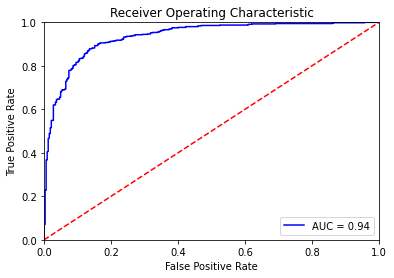

In [135]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr,tpr))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


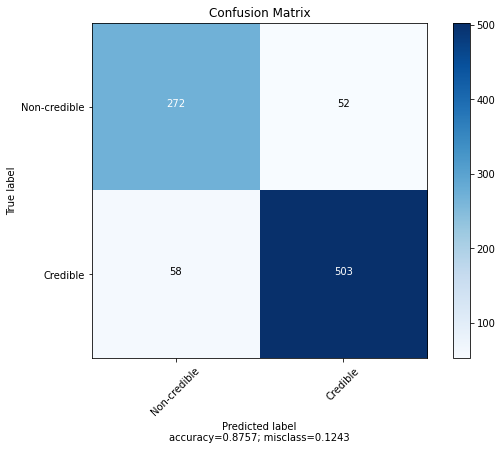

In [87]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(cm           = np.array([[272 ,52],[ 58 ,503]]), 
                      normalize    = False,
                      target_names = ['Non-credible', 'Credible'],
                      title        = "Confusion Matrix")

In [ ]:
# model.save('fasttext_attention+bilstm_best_model.h5')